Made by Yoonsoo P. Bach

# Comparison with Other Photometry Results
Although it is not described in the original paper, we made an internal comparison between our photometry results and the YMODP results (Hongu Yang, priv. comm.). We also compared it with the Spencer et al., 1995, Icarus, 117, 71 paper.

I compared the photometry results saved in ``phot_targ_4latex.csv`` with the following results:

1. The photometry results from YMODP
2. The observational log from Spencer et al 1995 paper

Both data files are included in this repo (``Toutatis_from_YMODP.csv``, ``SpencerJR_Table_digitize.csv``).
## Testing Environment

In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information scipy, numpy, matplotlib, pandas, astropy, callhorizons, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2019-03-05 10:31:44 (KST = GMT+0900) 
0 Python     3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
1 IPython    6.5.0
2 OS         Darwin 18.2.0 x86_64 i386 64bit
3 scipy      1.2.0
4 numpy      1.15.4
5 matplotlib 3.0.2
6 pandas     0.24.1
7 astropy    3.1.1
8 callhorizons 1.1.1
9 version_information 1.0.3


/Users/ysbach/anaconda3/lib/python3.6/site-packages/CALLHORIZONS-1.1.1-py3.6.egg/callhorizons/callhorizons.py:43: DeprecationWarning: CALLHORIZONS is not maintained anymore; please use astroquery.jplhorizons instead (https://github.com/astropy/astroquery)


## Comparison with YMODP

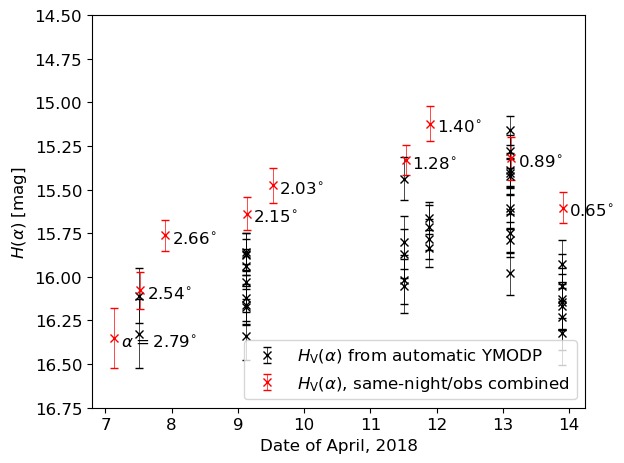

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
from astropy.time import Time

plt.style.use('default')
rcParams.update({'font.size':12})
V_SUN = -26.76
D2R = np.pi / 180
DATAPATH = Path("data")

errbfmt = dict(marker='x', ls='', elinewidth=0.5, capsize=3)

def iauHG(alpha, Gpar, degree=True):
    """ IAU H-G system. See ``iauHa2H0``.
    """
    if degree:
        aa = np.deg2rad(alpha)
    else:
        aa = alpha.copy()

    def exp(x):
        return np.exp(x)

    tanp2 = np.tan(aa / 2)  # tangent per 2 value
    term1 = Gpar * exp(-1.87 * tanp2**1.22)
    term2 = (1 - Gpar) * exp(-3.33 * tanp2**0.63)

    return term1 + term2


def iauHa2H0(Halpha, alpha, Gpar, degree=True):
    ''' Converts H(alpha) = V(1, 1, alpha) to H(0) using IAU HG model.
    Parameters
    ----------
    Halpha: float
        The reduced magnitude in mag unit.
    alpha: float
        The phase angle.
    Gpar: float
        The slope parameter. Usually 0.1 to 0.3.
    degree: bool
        Whether ``alpha`` is in degrees.
    '''
    H = Halpha + 2.5 * np.log10(iauHG(alpha=alpha, Gpar=Gpar, degree=degree))
    return H


#%%
# Load photometry data
phot = pd.read_csv(DATAPATH / "phot_targ_4latex.csv")
phot = phot.sort_values(by="datetime_jd")
alpha = phot["alpha"]
Ha = phot["m_red"]
dHa = phot["merr_red"]

# Load YMODP data
ymodp = pd.read_csv(DATAPATH / "Toutatis_from_YMODP.csv")
y_Ha = ymodp["M_obs [mag]"] - 5 * np.log10(ymodp["r"] * ymodp["delta"])
y_dHa = ymodp["M_err [mag]"]

# t_val = time from 2018-04-01 = t_target - t_ref
t_ref = Time('2018-04-01', format='isot').jd - 1
t_val = phot["datetime_jd"] - t_ref
y_t_val = ymodp["t_target"] - t_ref

fig, ax = plt.subplots(1, 1)

plt.errorbar(y_t_val, y_Ha, y_dHa, **errbfmt, color='k', 
             label=r"$H_\mathrm{V}(\alpha)$ from automatic YMODP")
plt.errorbar(t_val, Ha, dHa, **errbfmt, color='r', 
             label=r"$H_\mathrm{V}(\alpha)$, same-night/obs combined")
# Reverse the y-axis
plt.ylim(16.75, 14.5)

# Put the texts indicating phase angles
for i, a in enumerate(phot["alpha"]):
    if i == 0:
        plt.text(t_val[i]+0.1, Ha[i]+0.05, 
                 r'$\alpha = {:.2f}^{{\circ}}$'.format(a))
    else:
        plt.text(t_val[i]+0.1, Ha[i]+0.05, 
                 r'${:.2f}^{{\circ}}$'.format(a))

# Minor tuning
plt.legend(loc=4)
plt.ylabel(r"$H(\alpha)$ [mag]")
plt.xlabel("Date of April, 2018")
plt.tight_layout()
plt.show()

The results do overlap with each other in scertain sense. The mismatch might have caused by the following reasons:

1. YMODP uses SExtractor, because the main purpose of this pipeline is to *detect* moving objects (whether previously known or not), rather than accurate photometry. Since SExtractor does photometry from the summation of pixels with certain signal-to-noise ratio, it may lose some portion of the flux if the signal is weak. This is actually the case of our observation (SNR was ~ 3 at the lowest case). Especially if the target is elongated, the fraction of the lost flux of Toutatis is larger than that of sidereal targets, and thus the relative photometry will give lower brightness (higher magnitude) for the target than the true value.
2. Moreover, our photometry used a fixed aperture radius of 1.5 * seeing FWHM = 6 pixel = 2-3 arcsec. But the seeing FWHM of 4 pixels is sometimes an overestimate of the true FWHM, so the flux may be a bit more uncertain. Nevertheless, the flux value then is considered to include all the photons from the target, and hence the flux from our photometry is mostly larger than YMODP results.
3. We stacked the data to increase the signal-to-noise ratio. As a result, there are three places in the plot (x ~ 7, 8, 9.5) as red-markers where no corresponding black markers. YMODP did not detect Toutatis because we set the lower limit to the signal-to-noise ratio.


## Comparison with Spencer et al
First, from the observational log provided in their publication, I queried JPL HORIZONS to get ephemerides data. Then reproduced the plots in Spencer et al's publication


/Users/ysbach/anaconda3/lib/python3.6/site-packages/ccdproc/log_meta.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  (original_args, varargs, keywords, defaults) = inspect.getargspec(func)


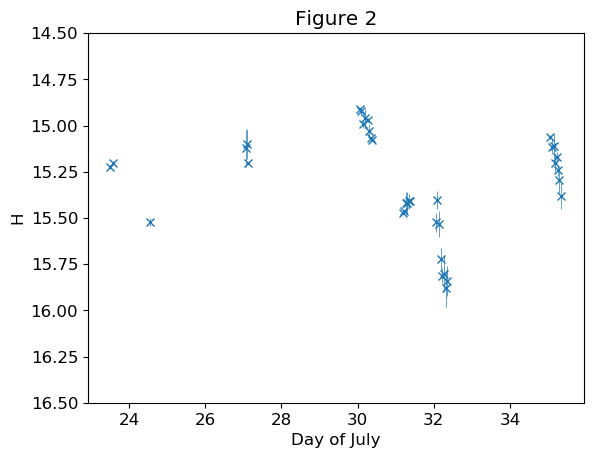

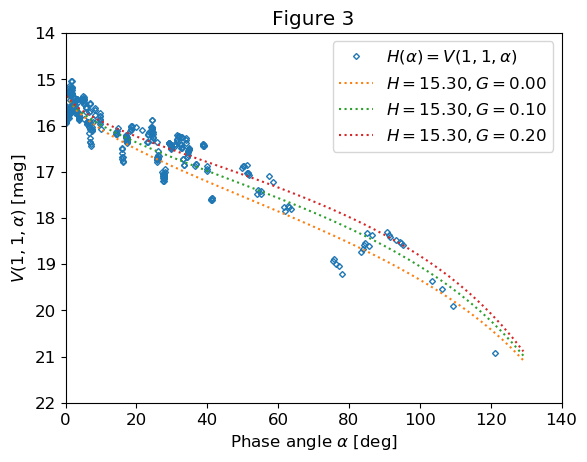

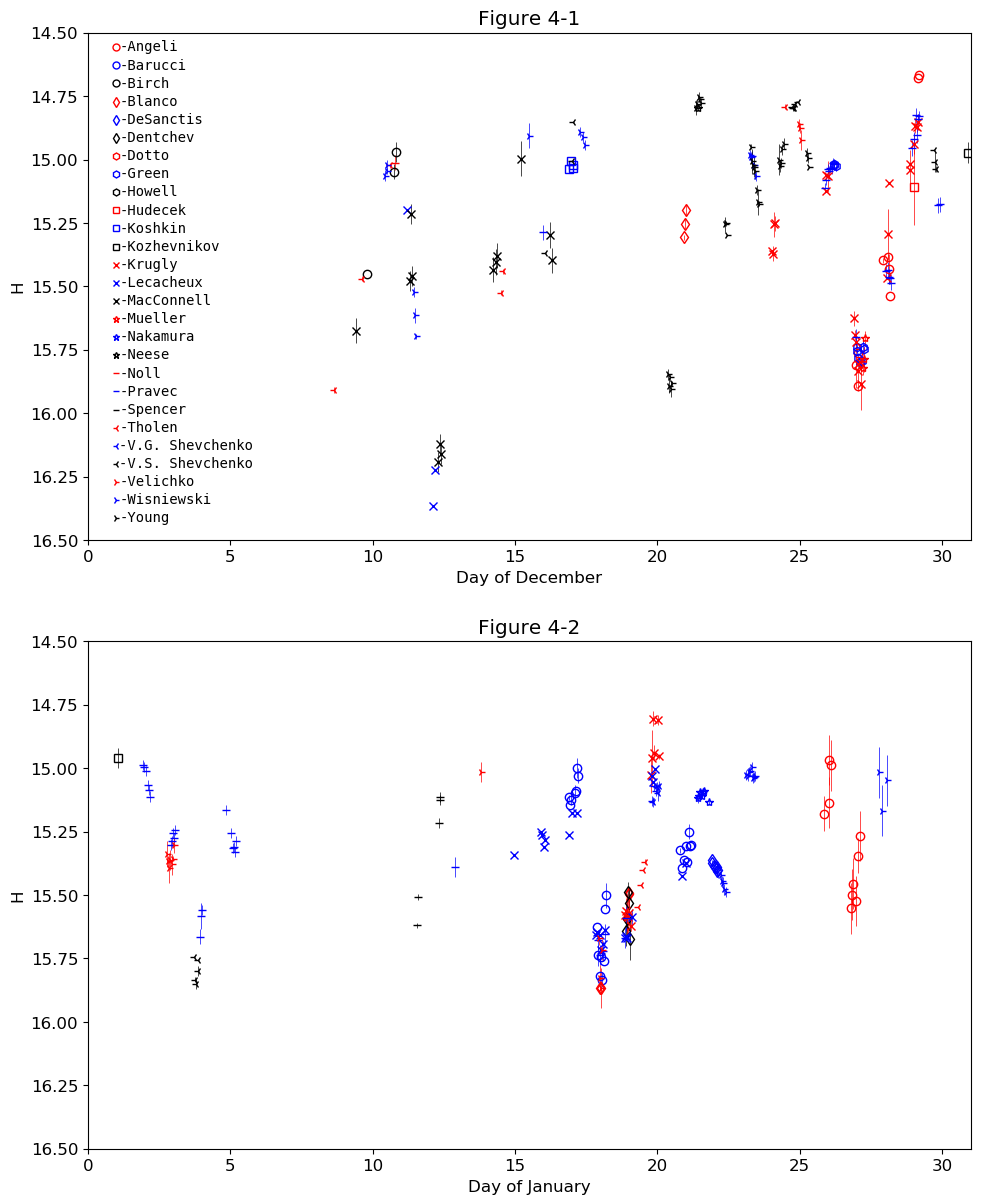

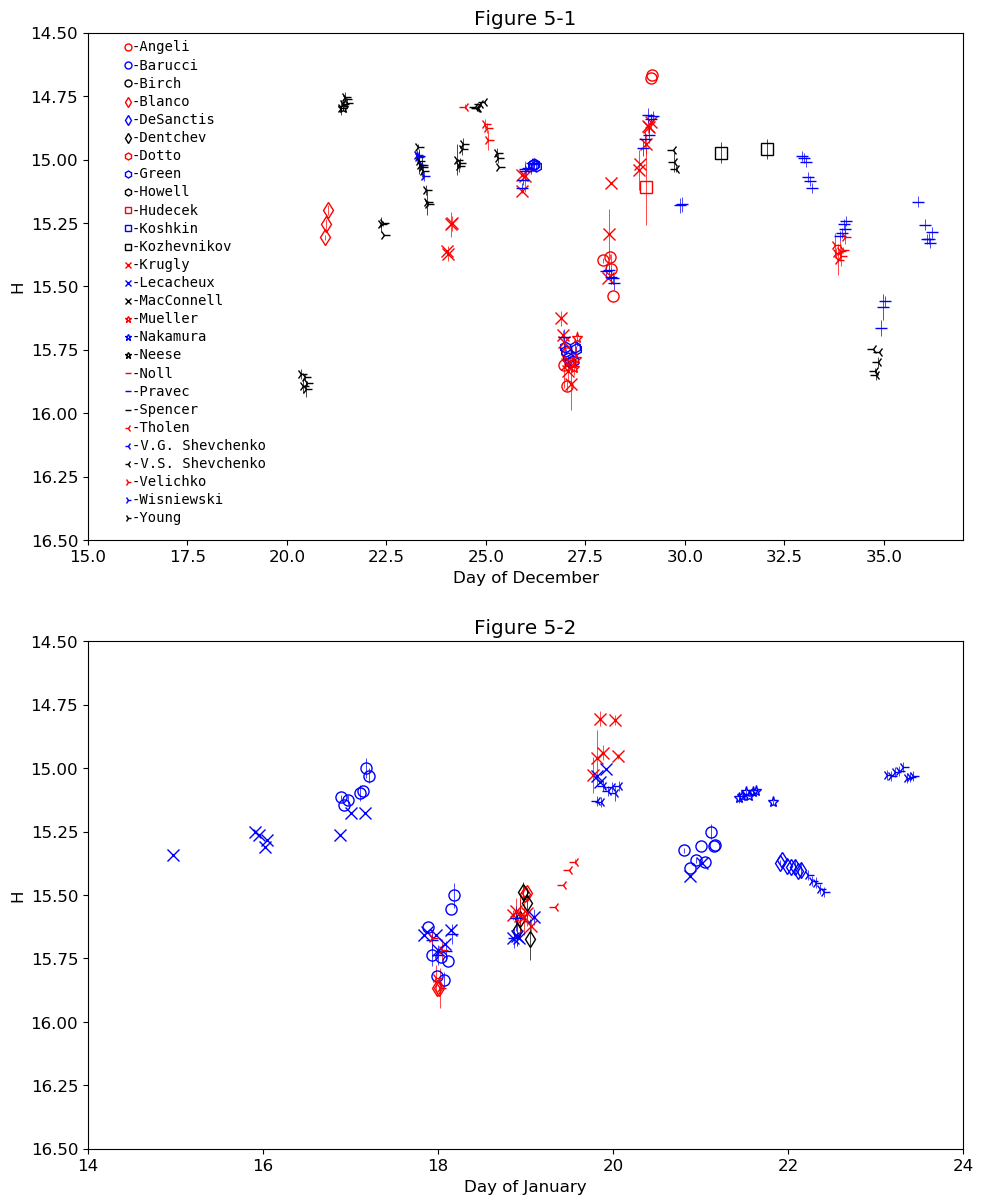

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from astropy.table import Table, hstack
from astropy.time import Time

from yspy.query import horizons
from yspy.util import fits_util as fu
from yspy.simulation import phase

comb = Table.read(DATAPATH / "SpencerJR_Table_digitize2.csv", format='ascii.csv')
FIX_GPAR = 0.1

obss = np.unique(comb["observer"]).tolist()

comb_few = comb[["jd", "dt_sec", "m", "merr", "observer"]]

# Fig 2
jd_ref = Time("1992-07-01T00:00:00").jd - 1
comb_tab1 = comb[:36]
plt.errorbar(comb_tab1["jd"] - comb_tab1["lighttime"]/86400 - jd_ref, 
             comb_tab1["H"], yerr=comb_tab1["merr"], 
             marker='x', ls='', capsize=0, elinewidth=0.5)
plt.ylim(16.5, 14.5)
plt.xlabel("Day of July")
plt.ylabel("H")
plt.title("Figure 2")
plt.show()
#%%
# Fig 3
FIX_HMAG = 15.30
alphas = np.arange(np.min(comb["alpha"]), np.max(comb["alpha"])+10, 3)

plt.plot(comb["alpha"], comb["H_alpha"], '.', marker='D', mfc='none', ms=3,
         label=r"$H(\alpha) = V(1, 1, \alpha)$")

for dG in [-0.1, 0.0, 0.1]:
    Gpar = FIX_GPAR + dG
    plt.plot(alphas, FIX_HMAG - 2.5 * np.log10(phase.iauHG(alphas, Gpar)), 
             ls=':', label=r"$H = {:.2f}, G = {:.2f}$".format(FIX_HMAG, Gpar))
plt.ylim(22, 14)
plt.xlim(0, 140)
plt.ylabel(r"$V(1, 1, \alpha)$ [mag]")
plt.xlabel(r"Phase angle $\alpha$ [deg]")
plt.legend()
plt.title("Figure 3")
plt.show()

#%%
# Fig 4
obsmarkers = ['o', 'd', 'h', 's', 'x', '*', '_', '3', '4']
obscolors = ['r', 'b', 'k']
obscm = dict()

jd_ref = [Time("1992-12-01T00:00:00").jd - 1, 
          Time("1993-01-01T00:00:00").jd - 1]
comb_tab2 = comb[40:202]
comb_tab3 = comb[202:]

plt.close('all')
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

for i, obs in enumerate(obss):
    i_m = i // 3
    i_c = i % 3
    obscm[obs] = dict(marker=obsmarkers[i_m], color=obscolors[i_c], mfc='none')
    axs[0].plot(1, 14.5 + 2 * (i+0.8) / 28, **obscm[obs], ms=5)
    axs[0].text(1.1, 14.5 + 2 * (i+1) / 28, '-' + obs, 
                fontdict={'family': 'monospace',
                          'size': 10})

for i, tab in enumerate([comb_tab2, comb_tab3]):
    tabobs = tab.group_by('observer')
    
    for byobs in tabobs.groups:
        obs = byobs[0]["observer"]
        mc = obscm[obs]
        axs[i].errorbar(byobs["jd"] - byobs["lighttime"]/86400 - jd_ref[i], 
                        byobs["H"], yerr=byobs["merr"], ls='', 
                        capsize=0, elinewidth=0.5, **mc)
        axs[i].set_xlim(0, 31)
        axs[i].set_ylim(16.5, 14.5)
        axs[i].set_ylabel('H')
        
axs[0].set_xlabel("Day of December")
axs[1].set_xlabel("Day of January")

plt.tight_layout()
plt.subplots_adjust(hspace=0.2, bottom=0.05)

axs[0].set_title("Figure 4-1")
axs[1].set_title("Figure 4-2")
plt.show()
#%%
# Fig 5

jd_ref = [Time("1992-12-01T00:00:00").jd - 1, 
          Time("1993-01-01T00:00:00").jd - 1]
comb_tab2 = comb[83:236]
comb_tab3 = comb[236:358]

plt.close('all')
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

for i, obs in enumerate(obss):
    i_m = i // 3
    i_c = i % 3
    axs[0].plot(16, 14.5 + 2 * (i+0.8) / 28, **obscm[obs], ms=5)
    axs[0].text(16.1, 14.5 + 2 * (i+1) / 28, '-' + obs, 
                fontdict={'family': 'monospace',
                          'size': 10})

for i, tab in enumerate([comb_tab2, comb_tab3]):
    tabobs = tab.group_by('observer')
    
    for byobs in tabobs.groups:
        obs = byobs[0]["observer"]
        mc = obscm[obs]
        time = byobs["jd"] - byobs["lighttime"]/86400 - jd_ref[i]
        axs[i].errorbar(time, byobs["H"], yerr=byobs["merr"], ls='', 
                        capsize=0, elinewidth=0.5, **mc, ms=8)
        axs[i].set_ylim(16.5, 14.5)
        axs[i].set_ylabel('H')

axs[0].set_xlim(15, 37)
axs[1].set_xlim(14, 24)
axs[0].set_xlabel("Day of December")
axs[1].set_xlabel("Day of January")

plt.tight_layout()
plt.subplots_adjust(hspace=0.2, bottom=0.05)

axs[0].set_title("Figure 5-1")
axs[1].set_title("Figure 5-2")
plt.show()

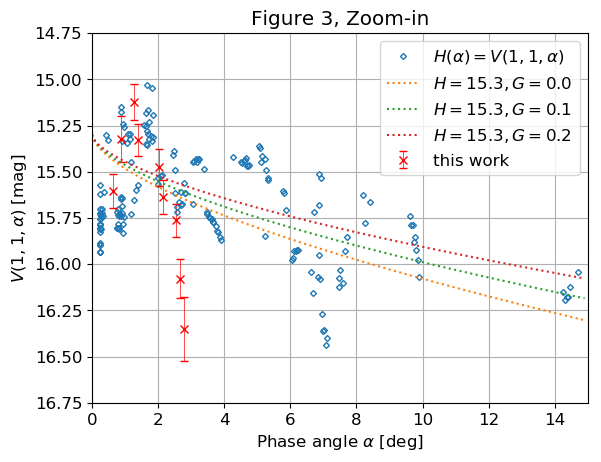

In [5]:
# Fig 3 zoom-in
FIX_HMAG = 15.30
amax = 15
alphas = np.arange(0, amax, 0.1)
zoomdata = comb[comb["alpha"] < amax]
ourdata = pd.read_csv(DATAPATH / "phot_targ_4latex.csv")

plt.plot(zoomdata["alpha"], zoomdata["H_alpha"], '.', marker='D', mfc='none', ms=3,
         label=r"$H(\alpha) = V(1, 1, \alpha)$")
plt.errorbar(ourdata["alpha"], ourdata["m_red"], yerr=ourdata["merr_red"], ls='', 
             marker='x', color='r', capsize=3, elinewidth=0.5, label="this work")

for dG in [-0.1, 0.0, 0.1]:
    Gpar = FIX_GPAR + dG
    plt.plot(alphas, FIX_HMAG - 2.5 * np.log10(phase.iauHG(alphas, Gpar)), 
             ls=':', label=r"$H = {:.1f}, G = {:.1f}$".format(FIX_HMAG, Gpar))
plt.ylim(16.75, 14.75)
plt.xlim(0, amax)
plt.grid()
plt.ylabel(r"$V(1, 1, \alpha)$ [mag]")
plt.xlabel(r"Phase angle $\alpha$ [deg]")
plt.legend()
plt.title("Figure 3, Zoom-in")
plt.show()

For a fair comparison, we converted our reduced magnitude to absolute magnitude using IAU H, G magnitude system using fixed G parameter of 0.10 as Spencer et al. did:

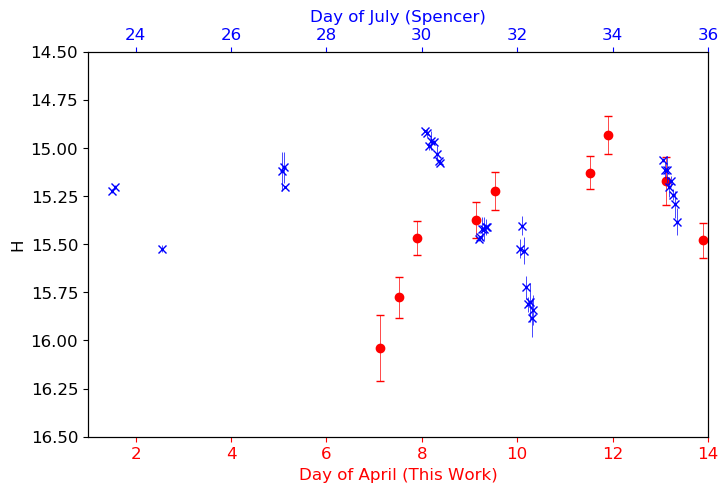

In [7]:
import numpy as np
import pandas as pd
def iauHG(alpha, Gpar, degree=True):
    """ IAU H-G system. See ``iauHa2H0``.
    """
    if degree:
        alpha = np.deg2rad(alpha)

    def exp(x):
        return np.exp(x)

    tanp2 = np.tan(alpha / 2)  # tangent per 2 value
    term1 = Gpar * exp(-1.87 * tanp2**1.22)
    term2 = (1 - Gpar) * exp(-3.33 * tanp2**0.63)

    return term1 + term2


def iauHa2H0(Halpha, alpha, Gpar, degree=True):
    ''' Converts H(alpha) = V(1, 1, alpha) to H(0) using IAU HG model.
    Parameters
    ----------
    Halpha: float
        The reduced magnitude in mag unit.
    alpha: float
        The phase angle.
    Gpar: float
        The slope parameter. Usually 0.1 to 0.3.
    degree: bool
        Whether ``alpha`` is in degrees.
    '''
    H = Halpha + 2.5 * np.log10(iauHG(alpha=alpha, Gpar=Gpar, degree=degree))
    return H

# Load photometry data
phot = pd.read_csv(DATAPATH / "phot_targ_4latex.csv")
phot = phot.sort_values(by="datetime_jd")
alpha = phot["alpha"]
Ha = phot["m_red"]
dHa = phot["merr_red"]
t_ref = Time('2018-04-01', format='isot').jd - 1
t_val = phot["datetime_jd"] - t_ref

# Calculate absolute magnitude
H0 = np.array(iauHa2H0(phot["m_red"], phot["alpha"], Gpar=0.10, degree=True))

# Load Spencer et al's data
spencer = Table.read(DATAPATH / "SpencerJR_Table_digitize2.csv", format='ascii.csv')
spencer1 = spencer[:36]
s_t_ref = Time("1992-07-01T00:00:00").jd - 1
s_t_val = spencer1["jd"] - spencer1["lighttime"]/86400 - s_t_ref

fig, ax = plt.subplots(figsize=(8, 5))

ax.errorbar(t_val, H0, yerr=dHa, marker='o', color='r', ls='', capsize=3, elinewidth=0.5)
ax.set_xlabel("Day of April (This Work)", color='r')
ax.set_ylabel("H")
ax.tick_params('x', colors='r')
ax.set_ylim(16.5, 14.5)
ax.set_xlim(1, 14)

ax2 = ax.twiny()
ax2.errorbar(s_t_val, spencer1["H"], yerr=spencer1["merr"], color='b',
             marker='x', ls='', capsize=0, elinewidth=0.5)
ax2.set_xlim(23, 36)
ax2.set_xlabel("Day of July (Spencer)", color='b')
ax2.tick_params('x', colors='b')
plt.show()


In the plot, I tuned the ``xlim`` to match the scales of two plots from Spencer and this work. As can be seen, the range of the H magnitudes do match with each other. Due to the complex rotational and precessional state of (4179) Toutatis, we cannot easily convert the time-series light curve into a phase-plot (i.e., x axis as the rotational phase).